In [1]:
%autosave 300
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%config Completer.use_jedi = False

Autosaving every 300 seconds


In [2]:
import os

os.chdir(
    "/mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/unstructured_data_experiments"
)
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/unstructured_data_experiments


##### __GPT4O_Parsing__

In [3]:
import os
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import AzureChatOpenAI
from langchain.prompts import (
    ChatPromptTemplate,
)
from dotenv import load_dotenv, find_dotenv
import base64
import requests
import json
from datetime import datetime
from langchain.schema import Document
import re
import shutil
from joblib import Parallel, delayed
from functools import partial
import pickle
from IPython.display import Image, display
from langchain_core.runnables import RunnableLambda
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
import asyncio
import nest_asyncio
from glob import glob

In [4]:
load_dotenv(find_dotenv('dev.env'))

True

In [5]:
def get_encode_image(image_path):
    """
    Encodes an image to base64 utf-8 string.

    Args:
    - image_path (str): Path to the image file.

    Returns:
    - str: Base64 encoded string of the image.
    """
    with open(image_path, "rb") as img_file:
        encoded_image = base64.b64encode(img_file.read()).decode("utf-8")
    return encoded_image

In [6]:
def get_gpt_model(
    azure_deployment,
    model_name,
    api_key,
    azure_endpoint,
    openai_api_type,
    api_version,
    temperature,
    request_timeout,
    max_retries,
    seed,
    top_p,
):
    """
    Returns an instance of the AzureChatOpenAI class.

    Args:
    - azure_deployment (str): Azure deployment name.
    - model_name (str): Name of the model.
    - api_key (str): API key.
    - azure_endpoint (str): Azure endpoint.
    - openai_api_type (str): OpenAI API type.
    - api_version (str): API version.
    - temperature (float): Temperature for sampling.
    - request_timeout (int): Request timeout.
    - max_retries (int): Maximum number of retries.
    - seed (int): Seed for random number generator.
    - top_p (float): Top-p sampling.

    Returns:
    - AzureChatOpenAI: Instance of the AzureChatOpenAI class.
    """

    llm_model = llm = AzureChatOpenAI(
        azure_deployment=azure_deployment,
        model_name=model_name,
        api_key=api_key,
        azure_endpoint=azure_endpoint,
        openai_api_type=openai_api_type,
        api_version=api_version,
        temperature=temperature,
        request_timeout=request_timeout,
        max_retries=max_retries,
        seed=seed,
        top_p=top_p,
    )

    return llm_model

In [7]:
def get_prompt(system_message):
    """
    Returns a ChatPromptTemplate instance with an image and system message.

    Args:
    - system_message (str): System message to display.

    Returns:
    - ChatPromptTemplate: Instance of the ChatPromptTemplate class.

    """
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_message),
            (
                "user",
                [
                    {
                        "type": "text",
                        "text": "Extract all the text from the image while considering most optimal ways to extract text out of tables and figures",
                    },
                    {
                        "type": "image_url",
                        "image_url": {"url": "data:image/jpeg;base64,{image_data}"},
                    },
                ],
            ),
        ]
    )
    return prompt

In [8]:
async def get_op_parser(response):
    """
    Returns the output parser for the response.

    Args:
    - response (str): Response from the model.

    Returns:
    - JsonOutputParser: Instance of the JsonOutputParser class.
    """
    response_op = response.dict()
    pg_content = response_op["content"]
    token_size = response_op["usage_metadata"]["output_tokens"]

    return json.dumps({"pg_content": pg_content, "token_size": token_size})

In [9]:
class ImageInformation(BaseModel):
    """Information extracted from the image in the form of free text."""

    pg_content: str = Field(
        description="Entire text extracted out of the image by the AI agent"
    )
    token_size: int = Field(
        description="Number of tokens recorded for the output text")


final_parser = JsonOutputParser(pydantic_object=ImageInformation)

In [10]:
async def image_to_text_chain(system_message: str, encoded_image: bytes, llm_model):
    """
    Extracts information from an image containing text, tables, and figures.

    Args:
    - system_message (str): System message to display.
    - encoded_image (bytes): Base64 encoded image.
    - llm_model (AzureChatOpenAI): Instance of the AzureChatOpenAI class.

    Returns:
    - ImageInformation: Information extracted from the image in the form of free text.
    """
    prompt = get_prompt(system_message)
    chain = prompt | llm_model | RunnableLambda(
        func=get_op_parser) | final_parser
    response_op = await chain.ainvoke({"image_data": encoded_image})
    return response_op

In [11]:
async def get_lc_document_from_response(response, image_path):
    """
    Creates a LangChain Document object from the GPT model's response.

    Args:
    - response (dict): Response from the GPT model.
    - image_path (str): Path to the image file.

    Returns:
    - Document: LangChain Document object containing extracted content and metadata.
    """
    if ".pdf" or ".jpeg" in image_path:
        image_path = image_path.replace(".pdf", "").replace(".jpeg", "")
    curr_time = datetime.now()
    whole_pdf_name = re.findall(r"(.*)_images\b", image_path.split("/")[-2])[0]
    file_name = whole_pdf_name.split("__")[-1]
    file_version = whole_pdf_name.split("__")[-2]
    contractor_name = whole_pdf_name.split("__")[-3]
    page_num = re.findall(r"page(\d+)", image_path.split("/")[-1])[0]

    # langchain document object

    doc = Document(
        page_content=response["pg_content"],
        metadata={
            "source": whole_pdf_name,
            "file_name": file_name,
            "file_version": file_version,
            "entity_name": contractor_name,
            "page_number": int(page_num),
            "token_size": response["token_size"],
            "timestamp": str(curr_time),
        },
    )

    return doc

In [12]:
async def final_image_extraction_pipeline(image_path, system_message, llm_model):
    """
    Extracts information from an image containing text, tables, and figures.

    Args:
    - image_path (str): Path to the image file.
    - system_message (str): System message to display.
    - llm_model (AzureChatOpenAI): Instance of the AzureChatOpenAI class.

    Returns:
    - Document: LangChain Document object containing extracted content and metadata
    """
    encoded_image = get_encode_image(image_path)
    response_op = await image_to_text_chain(system_message, encoded_image, llm_model)
    lc_doc = await get_lc_document_from_response(response_op, image_path)
    return lc_doc

In [13]:
llm_model = get_gpt_model(
    azure_deployment=os.getenv("CHAT_ENGINE_GPT4_DEPLOYMENT_NAME"),
    model_name=os.getenv("CHAT_ENGINE_GPT4_MODEL_NAME"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    openai_api_type=os.getenv("OPENAI_API_TYPE"),
    api_version=os.getenv("OPENAI_API_VERSION"),
    temperature=0.0,
    request_timeout=45,
    max_retries=5,
    seed=1234,
    top_p=0.0001,
)

In [14]:
system_message = (
    "You are an AI assistant specializing in extracting information from images containing three main components: "
    "`text`, `tables`, and `figures`. Your tasks are as follows:\n"
    "* Extract the `text` exactly as it appears in the image.\n"
    "* Extract data from `tables` while preserving the table structure, providing the data in a structured 2D format, "
    "and maintaining hierarchical columns if present and always ensuring the correct structure.\n"
    "* Extract and describe the information from `figures` in plain text format, making it understandable and reproducible "
    "from the extracted data.\n\n"
    "The final output should be in plain text format, containing only the extracted information from the original document."
)

Single Execution Mode

read the label tagged pickle file to read the images with needs gpt4O extraction

In [15]:
folder_name  = os.listdir("image_extracts")[-4]
print(folder_name)

Enteron__Original__MSA_Gateware_Enteron_images


In [16]:
path = f"image_extracts/{folder_name}"
image_label = pickle.load(open(f"{path}/images_labels.pkl", "rb"))

In [17]:
gpt4_images = list(
    {key: value for key, value in image_label.items() if value == 1}.keys()
)
print(f"Total images to be processed by GPT4O: {len(gpt4_images)}")

Total images to be processed by GPT4O: 7


In [18]:
normal_parsing_pages = [
    re.findall("\d+", k.split("/")[-1])[0]
    for k in list(
        {key: value for key, value in image_label.items() if value == 0}.keys()
    )
]
print(f"Total images to be processed by regular parsers: {len(normal_parsing_pages)}")

Total images to be processed by regular parsers: 25


In [19]:
import random

In [20]:
image_path = gpt4_images[random.randint(0, len(gpt4_images))]
print(image_path)

image_extracts/Enteron__Original__MSA_Gateware_Enteron_images/page32.jpeg


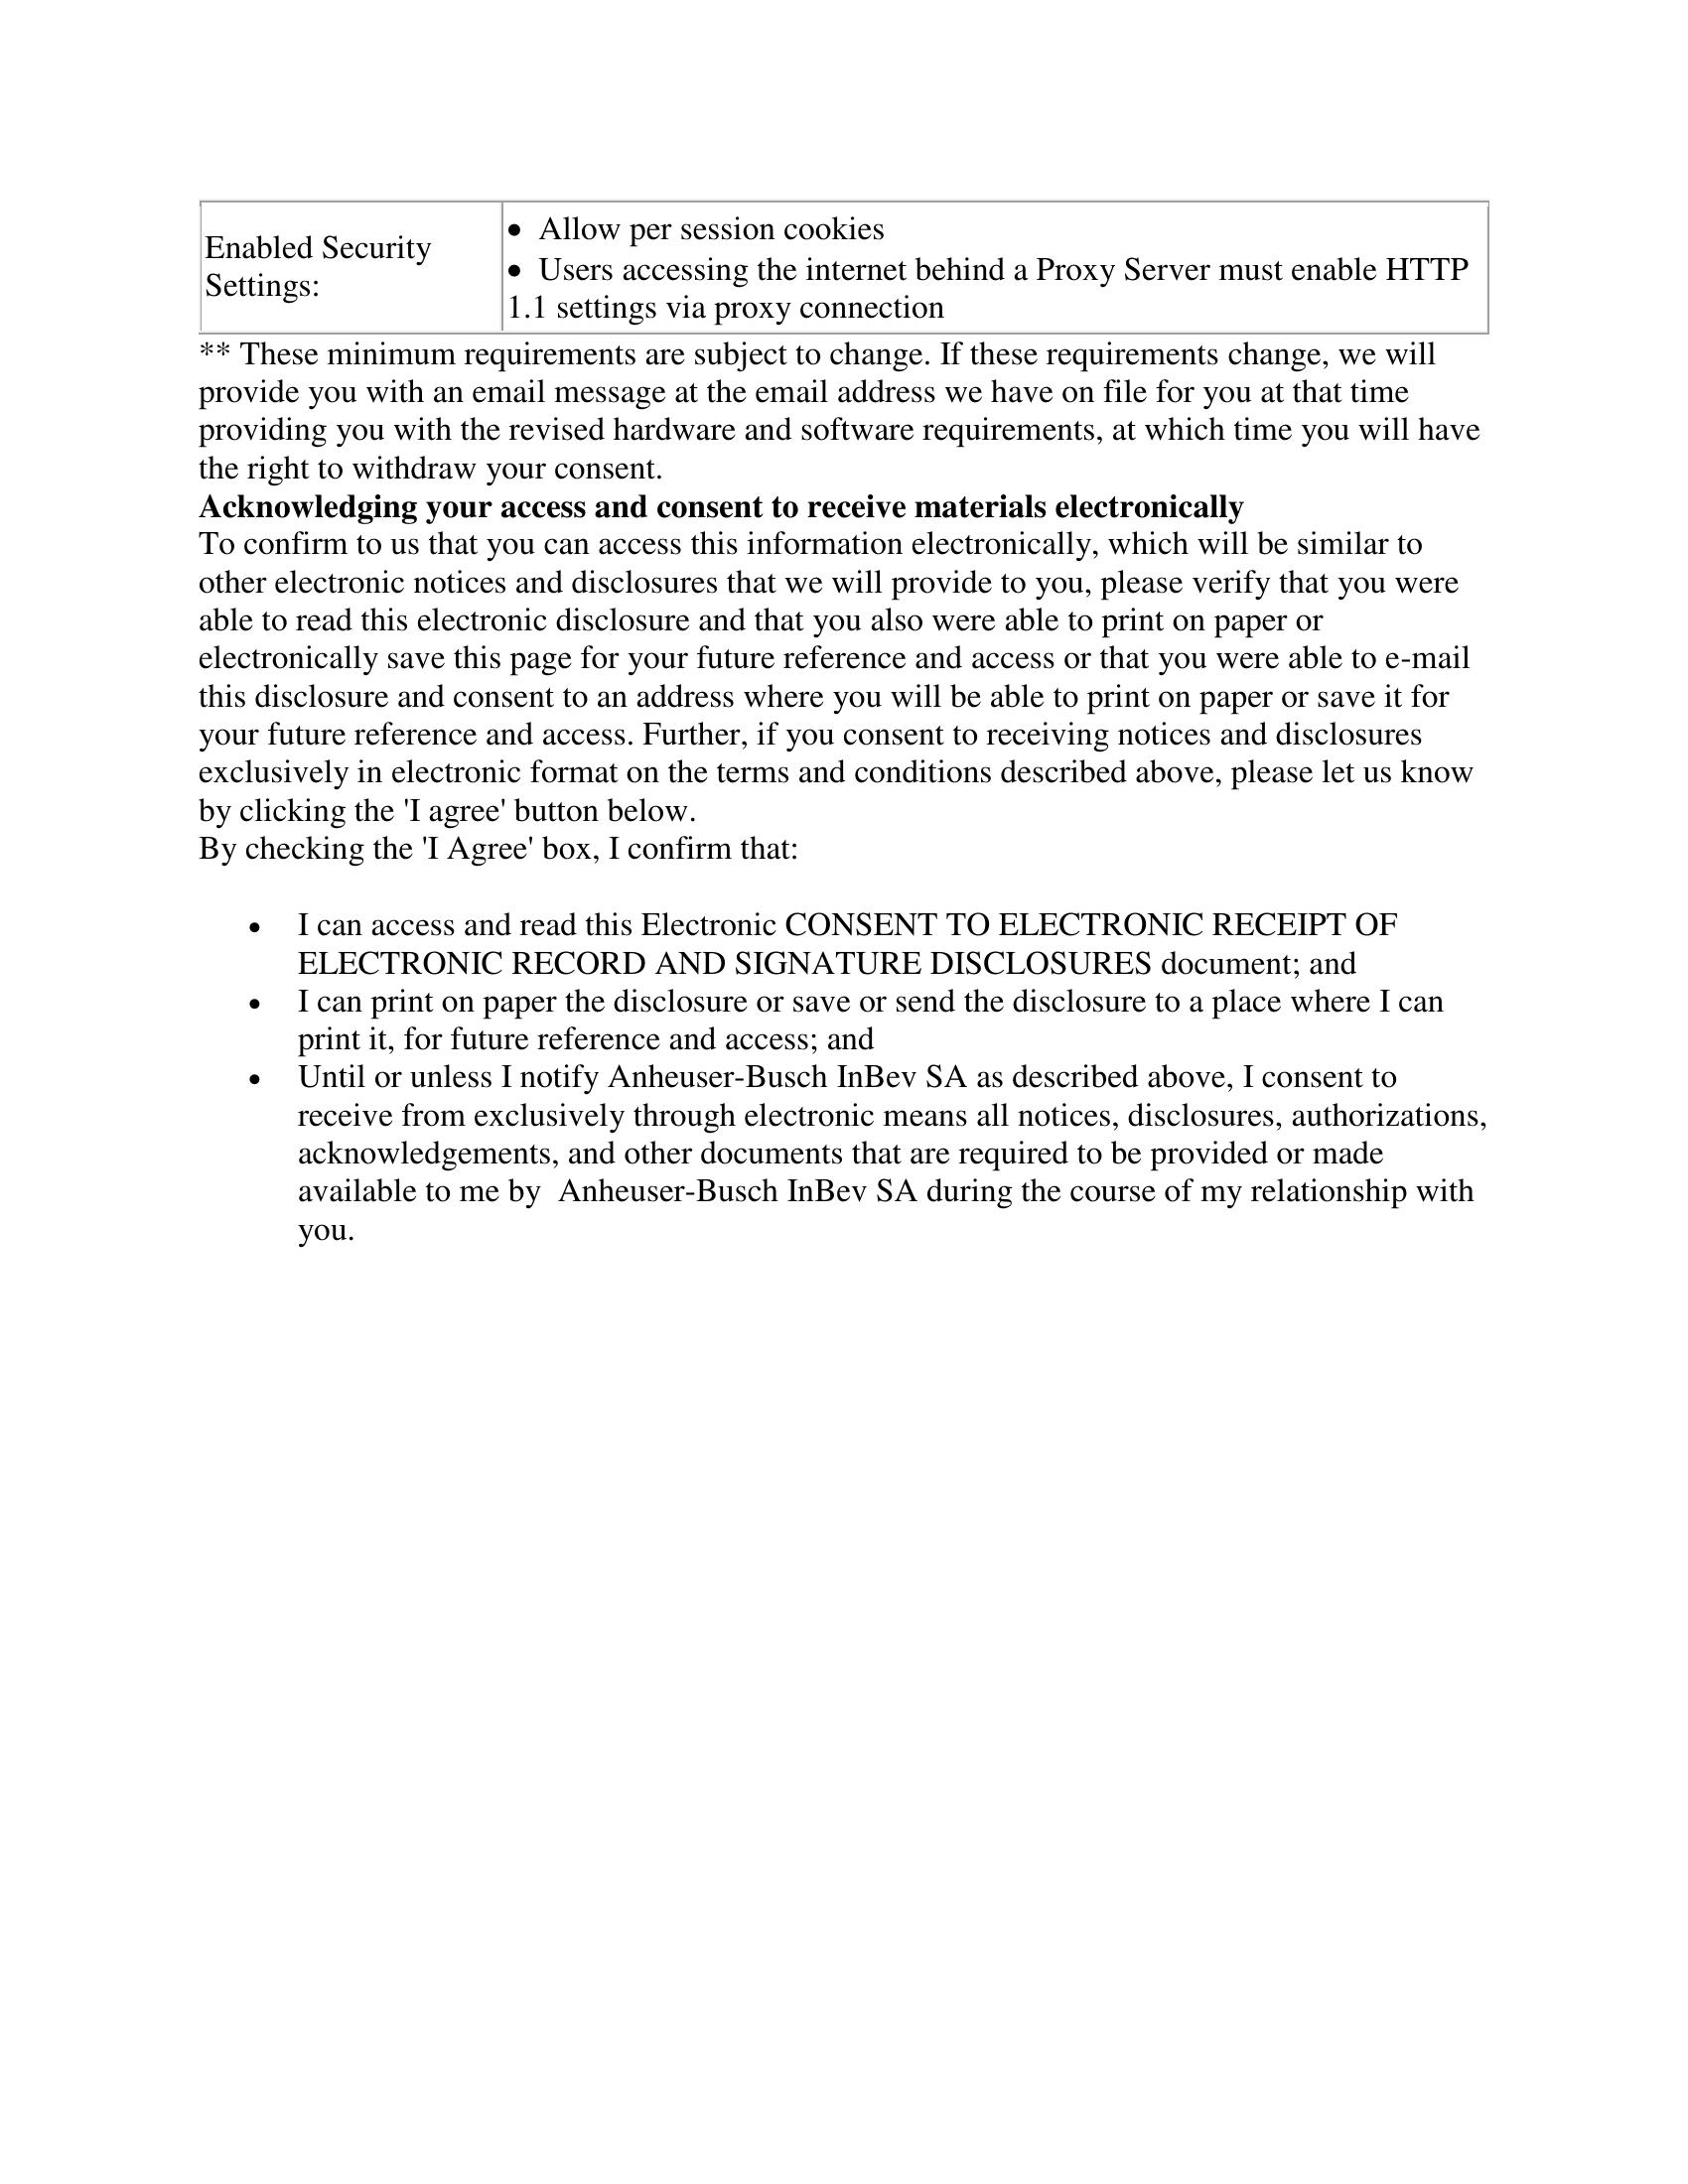

In [21]:
# Preview image for context
display(Image(image_path))

In [22]:
lc_doc = await final_image_extraction_pipeline(image_path, system_message, llm_model)

In [23]:
print(lc_doc.page_content)

```
Enabled Security Settings:
• Allow per session cookies
• Users accessing the internet behind a Proxy Server must enable HTTP 1.1 settings via proxy connection

** These minimum requirements are subject to change. If these requirements change, we will provide you with an email message at the email address we have on file for you at that time providing you with the revised hardware and software requirements, at which time you will have the right to withdraw your consent.

Acknowledging your access and consent to receive materials electronically
To confirm to us that you can access this information electronically, which will be similar to other electronic notices and disclosures that we will provide to you, please verify that you were able to read this electronic disclosure and that you also were able to print on paper or electronically save this page for your future reference and access or that you were able to e-mail this disclosure and consent to an address where you will be able t

In [24]:
print(lc_doc.metadata)

{'source': 'Enteron__Original__MSA_Gateware_Enteron', 'file_name': 'MSA_Gateware_Enteron', 'file_version': 'Original', 'entity_name': 'Enteron', 'page_number': 32, 'token_size': 382, 'timestamp': '2024-08-28 12:30:34.336385'}


##### __Parallel Code__

In [25]:
# Apply the patch to allow nested event loops
nest_asyncio.apply()  # only needed for jupyter notebooks remove for production

# Define a semaphore with a limit for concurrent tasks
semaphore = asyncio.Semaphore(
    3
)  # Change the number of parallel tasks you want to allow


async def process_image_with_semaphore(image_path, system_message, llm_model):
    async with semaphore:
        return await final_image_extraction_pipeline(
            image_path, system_message, llm_model
        )


async def process_images_parallel(image_paths, system_message, llm_model):
    """
    Processes a list of images in parallel using the final_image_extraction_pipeline function
    with a limit on the number of concurrent tasks.

    Args:
    - image_paths (list): List of image file paths.
    - system_message (str): System message to display.
    - llm_model (AzureChatOpenAI): Instance of the AzureChatOpenAI class.

    Returns:
    - list: List of LangChain Document objects containing extracted content and metadata.
    """
    # Create a list of tasks for processing each image
    tasks = [
        process_image_with_semaphore(image_path, system_message, llm_model)
        for image_path in image_paths
    ]

    # Run all tasks in parallel and gather the results
    documents = await asyncio.gather(*tasks, return_exceptions=True)

    return documents

In [26]:
lc_doc_ls = await process_images_parallel(gpt4_images, system_message, llm_model)

In [27]:
# keeping on doc class
lc_doc_ls = [doc for doc in lc_doc_ls if isinstance(doc, Document)]

In [28]:
len(lc_doc_ls)

7

In [29]:
lc_doc_ls[0]

Document(metadata={'source': 'Enteron__Original__MSA_Gateware_Enteron', 'file_name': 'MSA_Gateware_Enteron', 'file_version': 'Original', 'entity_name': 'Enteron', 'page_number': 1, 'token_size': 849, 'timestamp': '2024-08-28 12:30:59.391308'}, page_content='DocuSign Envelope ID: 3BDE136F-BA28-419D-A682-AAAD1BA87428\n\nAgreement Reference No:\n\nMASTER AGREEMENT (SERVICES)\n\nThis Agreement is made on April 17th 2023 ("Effective Date")\n\nBETWEEN\n\n(1) Anheuser-Busch InBev Procurement GmbH, a Swiss company which has its registered office at Suurstoffi 22, Rotkreuz, 6343, Switzerland ("AB InBev"); and\n\n(2) AmBev Luxembourg SARL Senningerberg, Risch Branch, a Swiss branch of a Luxembourg company which has its registered office at Suurstoffi 22, Rotkreuz, 6343, Switzerland ("AmBev Luxembourg"),\n\n(together "AB InBev"); and\n\n(3) Enteron Tecnologia da Informação LTDA, a Brazilian company which has its registered office at 10, ST Beija-flor, Montparnass, Almirante Tamandaré, Paraná ("Ga

In [30]:
# print(lc_doc_ls[77].page_content)

In [31]:
# print(lc_doc_ls[77].metadata)

##### __RegularParserExtraction__

In [35]:
from langchain_community.document_loaders import PyPDFLoader, PyPDFium2Loader, PDFPlumberLoader
import tiktoken
import pdfplumber

In [36]:
print(normal_parsing_pages)

['10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '27', '3', '30', '4', '5', '6', '7', '8', '9']


In [37]:
folder_name

'Enteron__Original__MSA_Gateware_Enteron_images'

In [38]:
org_file_path = folder_name.replace("__", "/").replace("_images", ".pdf")
data_path = f"contracts/{org_file_path}"
print(data_path)

contracts/Enteron/Original/MSA_Gateware_Enteron.pdf


In [39]:
# pdf = pdfplumber.open(
#     "./contracts/Mouts/Original/MSA- Services MOUTS REVISED - April 16th v7 (2) 3.pdf",
# )

In [40]:
loader = PyPDFium2Loader(data_path)
docs = loader.load()
print(len(docs))

/anaconda/envs/langchain_unstructured/lib/python3.10/site-packages/pypdfium2/_helpers/textpage.py:80: UserWarning: get_text_range() call with default params will be implicitly redirected to get_text_bounded()
  warnings.warn("get_text_range() call with default params will be implicitly redirected to get_text_bounded()")


32


In [41]:
# remove thise content where page number is not in normal_parsing_pages
docs = [doc for doc in docs if str(doc.metadata["page"]) in normal_parsing_pages]
print(len(docs))
assert len(docs) == len(normal_parsing_pages), "Number of pages mismatch"

25


In [42]:
# calculate tiktoken token count
def num_tokens_from_string(string: str, encoding_name: str = "cl100k_base") -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [43]:
async def get_lc_document_from_response(docs, data_path):
    """
    Creates a LangChain Document object from the LC pdf parser response.

    Args:
        docs: list of LangChain Document objects containing extracted content and metadata.
        data_path: str, path to the pdf file.

    Returns:
        doc: list of LangChain Document objects containing extracted content and metadata.

    """
    if ".pdf" or ".jpeg" in data_path:
        data_path = data_path.replace(".pdf", "").replace(".jpeg", "")

    curr_time = datetime.now()
    whole_pdf_name = (
        data_path.split("/")[-3]
        + "__"
        + data_path.split("/")[-2]
        + "__"
        + data_path.split("/")[-1]
    )
    file_name = data_path.split("/")[-1]
    entity_name = data_path.split("/")[-3]
    file_version = data_path.split("/")[-2]

    # langchain document object , restructing the response

    doc = [
        Document(
            page_content=doc.page_content,
            metadata={
                "source": whole_pdf_name,
                "file_name": file_name,
                "page_number": doc.metadata["page"],
                "token_size": num_tokens_from_string(doc.page_content),
                "timestamp": str(curr_time),
                "entity_name": entity_name,
                "file_version": file_version,
            },
        )
        for doc in docs
    ]

    return doc

In [44]:
pdf_parsed_docs = await get_lc_document_from_response(docs, org_file_path)

In [45]:
assert (
    pdf_parsed_docs[0].metadata.keys() == lc_doc_ls[0].metadata.keys()
), "Metadata keys mismatch for both parsers"

In [46]:
print(pdf_parsed_docs[0].page_content)

Agreement Reference No:
Page | 3
ICLM_ExtSignature:1
Signed for and on behalf of
Enteron Tecnologia da Informação LTDA
Name:Ext1Text68810|Name 1|ICM-NOATTRIBUTE|0|0|0|0|ICM-NO-ATTRIBUTE|ICM-NOVALUE|#%#|
Title: Ext1Text53492|Title 1|ICM-NOATTRIBUTE|1|0|0|0|ICM-NO-ATTRIBUTE|ICM-NOVALUE|#%#|
Date: ExtDate1
ICLM_ExtSignature:2
Signed for and on behalf of 
Enteron Tecnologia da Informação LTDA
Name: Ext2Text84436|Name 2|ICM-NOATTRIBUTE|0|0|0|0|ICM-NO-ATTRIBUTE|ICM-NOVALUE|#%#|
Title: Ext2Text51673|Title 2|ICM-NOATTRIBUTE|1|0|0|0|ICM-NO-ATTRIBUTE|ICM-NOVALUE|#%#|
Date: ExtDate2
DocuSign Envelope ID: 3BDE136F-BA28-419D-A682-AAAD1BA87428
25 de abril de 2023
CEO
Julia Dainezi Fernandes FRANCISCO FERREIRA
Account Manager
26 de abril de 2023



In [47]:
# adding up both list of parsed documents and extracted documents from GPT4O and sorting them by page number
all_docs = sorted(pdf_parsed_docs + lc_doc_ls, key=lambda x: x.metadata["page_number"])

In [48]:
os.makedirs(f"extracted_docs/{folder_name}", exist_ok=True)
pickle.dump(
    all_docs, open(f"extracted_docs/{folder_name}/extracted_docs_all_parsed.pkl", "wb")
)

##################################################################################################################################